# 딥러닝 들여다보기

------------------
### 목차
2. 신경망 구성
  + 개요
  + 활성화 함수와 손실 함수
4. 경사하강법
  + 경사하강법 기초를 직접 NumPy로 만들면서 원리를 잉해할 수 있습니다.
5. 오차역전법이란?
  + 오차역전법으로 예측값과 실제 label된 값을 비교할 수 있습니다.
6. 모델 학습 Step-by-Step
  + 위에서 했던 내용을 반복하면서 코드를 구현할 수 있습니다.
7. 추론 과정 구현과 정확도 계산
  + 모델 학습 이후 추론과 정확도를 계산해 모델 학습의 완성도를 높일 수 있습니다.
8. 전체 학습 사이클 수행
  + 전체 학습 사이클을 홀로 구현해 원리를 조금 더 깊게 파악할 수 있습니다.

### 학습 목표
* 딥러닝 문제 구성에 대한 기본적인 이해를 높입니다.
* Neural Network에 사용되는 용어들에 대한 이해를 높입니다.
* 딥러닝 프레임워크를 사용하지 않고, NumPy만을 이용해 딥러닝 모델과 훈련 과정을 직접 구현해 봅니다.

------------------------

## 12-2. 신경망 구성 (1) 개요

신경망(Neural Network)구조에 퍼셉트론(Perceptron)이라는 형태를 제안하며 인공신경망(Arificial Neural Network)이라 부르기 시작했다.

딥러닝 모델을 시작할 때 가장 흔히 다루는 MNIST라는 숫자 이미지 데이터를 분류해보자.


In [17]:
from keras.api._v2.keras import activations
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# MNIST 데이터 불러오고, 나누기
mnist = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# print(x_train.shape)
# print(x_train[1,:,:])

# 모델에 맞게 데이터 가공,
x_train_norm, x_test_norm = x_train/255.0, x_test/255.0 #0~255인 데이터를 0~1로
#  이미지 하나에 (1,28,28)인 데이터를 (1,28*28)로 변환
x_train_reshaped = x_train_norm.reshape(-1,x_train_norm.shape[1]*x_train_norm.shape[2]) 
x_test_reshaped = x_test_norm.reshape(-1,x_test_norm.shape[1]*x_test_norm.shape[2])

# 모델 구성 - 2 Layer Perceptron
model = keras.models.Sequential()
# 입력층 d=784(28*28), 은닉층 레이어 H=50 , 출력층 레이어 K=10
model.add(keras.layers.Dense(50, activation='sigmoid', input_shape=(784,)))
model.add(keras.layers.Dense(10, activation='softmax'))
model.summary()

# 모델 학습
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train_reshaped, y_train, epochs=2)

# 모델 테스트 결과
test_loss, test_accuracy = model.evaluate(x_test_reshaped, y_test, verbose=2)
print(f"test_loss : {test_loss}")
print(f"test_accuracy : {test_accuracy}")

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 50)                39250     
                                                                 
 dense_17 (Dense)            (None, 10)                510       
                                                                 
Total params: 39,760
Trainable params: 39,760
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4928 - accuracy: 0.8822
Epoch 2/2
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2307 - accuracy: 0.9339
313/313 - 1s - loss: 0.1985 - accuracy: 0.9418 - 506ms/epoch - 2ms/step
test_loss : 0.19852294027805328
test_accuracy : 0.9417999982833862


### 다층 퍼셉트론 Overview

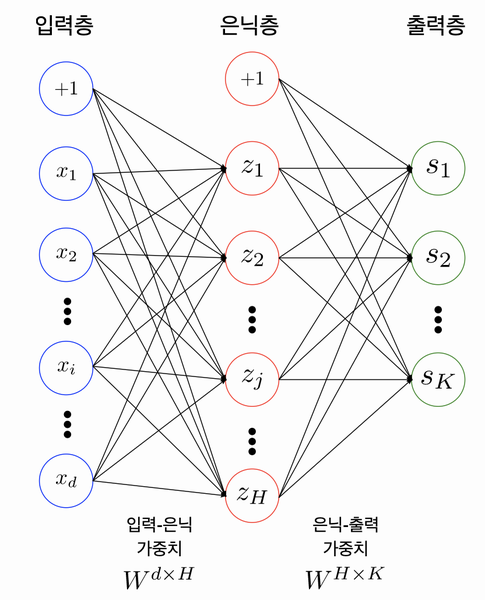

위 이미지는 입력층(input layer), 출력층(output layer), 입력층과 출력층 사이에 있는 층(layer)들은 전부 은닉층이다.

또한 그림으로 인공신경망을 표현할때 위는 2개의 레이어를 가진 신경망이다.

### Parameters/Weights

입력값이 100개, 은닉 노드가 20개라면 입력층과 은닉층 사이에는 100*20의 행렬이 존재한다. 입력층과 은닉층 사이의 가중치(Weight)이며 모델의 파라미터(Parameter)이다.

In [18]:
# 입력층 데이터의 모양(shape)
print(x_train_reshaped.shape)

# 테스트를 위해 x_train_reshaped의 앞 5개의 데이터를 가져온다.
X = x_train_reshaped[:5]

weight_init_std = 0.1
input_size = 784
hidden_size=50

# 인접 레이어간 관계를 나타내는 파라미터 W를 생성하고 random 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)  
# 바이어스 파라미터 b를 생성하고 Zero로 초기화
b1 = np.zeros(hidden_size)

a1 = np.dot(X, W1) + b1   # 은닉층 출력

print(f'W1.shape:',W1.shape)
print(f'X.shape:',X.shape)
print(f'b1.shape:', b1.shape)
print(f'a1.shape:',a1.shape)

(60000, 784)
W1.shape: (784, 50)
X.shape: (5, 784)
b1.shape: (50,)
a1.shape: (5, 50)


## 12-3. 신경망 구성 (2) 활성화 함수와 손실 함수

### 활성화 함수 (Activation Functions)

1. Sigmoid
  + sigmoid는 예전 많이 써오던 함수지만 현재는 기울기 소실현상과 exp함수의 사용 비용으로 ReLU를 많이 사용한다.
$$
\sigma(x)=\frac{1}{1+e^{-x}}$$

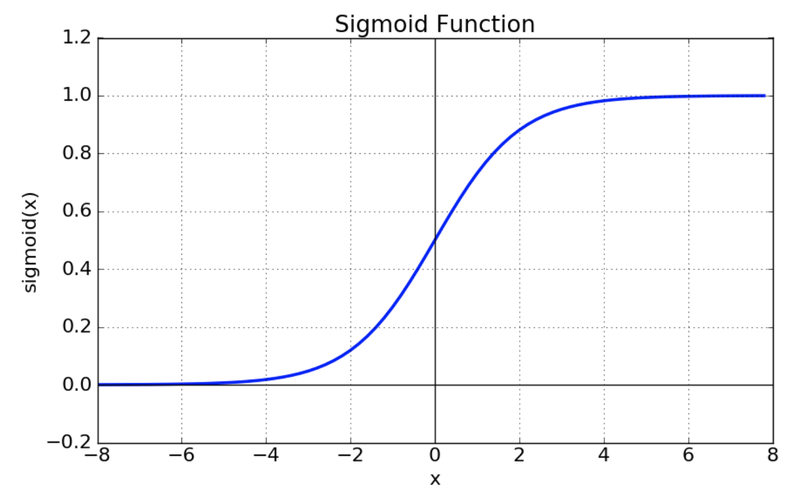

2. Tanh
  + sigmoid의 최적화 과정이 느려지는 문제를 해결, 기울기 손실 문제가 있다.
$$
tanh(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$

![image.png](https://d3s0tskafalll9.cloudfront.net/media/images/f-14-3.max-800x600.png)

3. ReLU
  + 위 두 함수에 비해 학습이 빠르다. 구현이 간단하며 기울기 손실 문제를 해결했다.

![image](https://d3s0tskafalll9.cloudfront.net/media/images/f-14-4.max-800x600.png)

In [19]:
# 위 수식의 sigmoid 함수를 구현해 봅니다.
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  


z1 = sigmoid(a1)
print(z1[0])  # sigmoid의 출력은 모든 element가 0에서 1사이

[0.8960625  0.35216144 0.79991953 0.70632458 0.63136224 0.65110758
 0.08209168 0.79228583 0.83622442 0.38460596 0.74750181 0.66491071
 0.58532395 0.49959006 0.28093224 0.48679832 0.64931178 0.42714452
 0.67652441 0.5729734  0.75873491 0.34686037 0.27040533 0.53709852
 0.41461099 0.65198507 0.29737345 0.72836518 0.48004843 0.28966285
 0.69346094 0.24910758 0.0834601  0.86057373 0.38072759 0.62918727
 0.70426834 0.1845842  0.39467956 0.48570722 0.24194554 0.33310946
 0.91707658 0.54399482 0.24831148 0.47301548 0.52535472 0.50649525
 0.72213851 0.2853924 ]


In [33]:
# 단일 레이어 구현 함수
def affine_layer_forward(X, W, b):
    y = np.dot(X, W) + b
    cache = (X, W, b)
    return y, cache

In [34]:

# weight_init_std = 0.1
# input_size = 784
# hidden_size=50
weight_init_std = 0.1
input_size = 784
hidden_size = 50
output_size = 10

W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)    # z1이 다시 두번째 레이어의 입력이 됩니다. 

print(a2[0])  # 최종 출력이 output_size만큼의 벡터가 되었습니다.

[ 0.06226032 -0.37456471  0.34328533  0.58378481 -0.30897193  0.04573766
  0.11361588 -0.44215651  0.20322313  0.69941938]


In [70]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

y_hat = softmax(a2)
y_hat[0]  # 10개의 숫자 중 하나일 확률이 되었습니다.
print(a2.T)
print( np.max(a2.T, axis=0))

[[ 0.6261253   0.72195655  0.73636405  0.80019291  0.87689733]
 [ 0.22988963  0.36381841  0.18118647  0.11774042  0.10236668]
 [-0.28960153 -0.4811917  -0.23000643 -0.40066892 -0.19703068]
 [-0.03558798 -0.03995919 -0.05603983 -0.06527917  0.01098265]
 [ 0.30383172  0.28302558  0.11417122  0.11934555  0.05866754]
 [-0.16121998 -0.12240204 -0.18514911  0.08710779 -0.09126912]
 [-0.39061757 -0.35639508 -0.5081451  -0.34445439 -0.42221396]
 [-0.55315124 -0.56101983 -0.50897035 -0.36757946 -0.43823949]
 [ 0.44503471  0.42850343  0.29468197  0.29045936  0.32968895]
 [ 0.1048513   0.08396823  0.21170405  0.0837697   0.15150517]]
[0.6261253  0.72195655 0.73636405 0.80019291 0.87689733]


### 손실함수(Loss Functions)

위의 비선형 활성화 함수를 가진 여러 개의 은닉층을 거친 다음 출력층으로 전달된다. 이때 정답과 출력값의 차이를 계산하고, 이 차이를 줄이기 위해 각 파라미터들을 조정하는 것이 딥러닝의 전체적인 학습 흐름이다.

* **평균제곱오차(MSE:Mean Square Error)**
  +  이름이 곧 내용이다.
$$
MSE=\frac{1}{n}\sum_{i+1}^n (Y_i-\hat{Y_i})^2$$

* **교차 엔트로피(Cross Entropy)**
  + 두 확률분포 사이의 유사도가 클수록 작아지는 값.
  $$
  E=-\sum_{i=1}^n t_i \text{log }y_i$$
  



In [26]:
# 정답 라벨을 One-hot 인코딩하는 함수
def change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1   
    return T

Y_digit = y_train[:5]
t = change_one_hot_label(Y_digit, 10)
t     # 정답 라벨의 One-hot 인코딩

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [27]:
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

Loss = cross_entropy_error(y_hat, t)
Loss

2.359254138649258

## 12-4. 경사하강법

함수의 최소값을 찾아가는 방법이고, 따라서 최적값을 찾아가는 방법이다. 이를 위해 찾아가는 보폭인 학습률과 하이퍼 변수들의 값을 초기화하여 진행한다.

![step_size](https://raw.githubusercontent.com/angeloyeo/angeloyeo.github.io/master/pics/2020-08-16-gradient_descent/pic4.png)

![localminima](https://raw.githubusercontent.com/angeloyeo/angeloyeo.github.io/master/pics/2020-08-16-gradient_descent/pic5.png)

In [35]:
# 
batch_num = y_hat.shape[0]
dy = (y_hat - t) / batch_num
print(y_hat.shape)

dW2 = np.dot(z1.T, dy)    

dW2 = np.dot(z1.T, dy)
db2 = np.sum(dy, axis=0)



(5, 10)


In [36]:
def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

In [37]:
learning_rate = 0.1

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
    W1 = W1 - learning_rate*dW1
    b1 = b1 - learning_rate*db1
    W2 = W2 - learning_rate*dW2
    b2 = b2 - learning_rate*db2
    return W1, b1, W2, b2

## 12-5. 오차역전파법이란?

위의 기울기를 입력층까지 전달하며 가중치들을 업데이트 해야한다. 이를 하기위해 **오차역전파법(Backpropagation)**을 진행한다.


In [39]:
def affine_layer_backward(dy, cache):
    X, W, b = cache
    dX = np.dot(dy, W.T)
    dW = np.dot(X.T, dy)
    db = np.sum(dy, axis=0)
    return dX, dW, db

In [41]:
# 파라미터 초기화
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

# Forward Propagation
a1, cache1 = affine_layer_forward(X, W1, b1)
z1 = sigmoid(a1)
a2, cache2 = affine_layer_forward(z1, W2, b2)

# 추론과 오차(Loss) 계산
y_hat = softmax(a2)
t = change_one_hot_label(Y_digit, 10)   # 정답 One-hot 인코딩
Loss = cross_entropy_error(y_hat, t)

print(y_hat)
print(t)
print('Loss: ', Loss)
        
dy = (y_hat - t) / X.shape[0]
dz1, dW2, db2 = affine_layer_backward(dy, cache2)
da1 = sigmoid_grad(a1) * dz1
dX, dW1, db1 = affine_layer_backward(da1, cache1)

# 경사하강법을 통한 파라미터 업데이트    
learning_rate = 0.1
W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)

[[0.17047471 0.11470358 0.06822835 0.08795925 0.12350645 0.07757472
  0.06167287 0.05242116 0.14223724 0.10122168]
 [0.18409565 0.12867854 0.05527425 0.08593058 0.11869112 0.07913038
  0.0626212  0.05103334 0.13727722 0.09726772]
 [0.19408028 0.11139632 0.07384006 0.08787084 0.10417572 0.07722774
  0.05591109 0.05586497 0.1247847  0.11484827]
 [0.20234606 0.10226085 0.06089296 0.08515791 0.10242512 0.09917582
  0.06441407 0.06294158 0.12154029 0.09884532]
 [0.21513934 0.09916204 0.07350533 0.09050194 0.09492206 0.08170535
  0.05868444 0.05775149 0.1244716  0.10415642]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.2105159009887707


In [42]:
W1 = weight_init_std * np.random.randn(input_size, hidden_size)
b1 = np.zeros(hidden_size)
W2 = weight_init_std * np.random.randn(hidden_size, output_size)
b2 = np.zeros(output_size)

def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
    a1, cache1 = affine_layer_forward(X, W1, b1)
    z1 = sigmoid(a1)
    a2, cache2 = affine_layer_forward(z1, W2, b2)
    y_hat = softmax(a2)
    t = change_one_hot_label(Y, 10)
    Loss = cross_entropy_error(y_hat, t)

    if verbose:
        print('---------')
        print(y_hat)
        print(t)
        print('Loss: ', Loss)
        
    dy = (y_hat - t) / X.shape[0]
    dz1, dW2, db2 = affine_layer_backward(dy, cache2)
    da1 = sigmoid_grad(a1) * dz1
    dX, dW1, db1 = affine_layer_backward(da1, cache1)
    
    W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
    
    return W1, b1, W2, b2, Loss

In [43]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복 돌립니다.
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.08536519 0.06021855 0.07294981 0.06923675 0.13729602 0.22443262
  0.07807855 0.06044615 0.14711946 0.0648569 ]
 [0.09096379 0.06870435 0.0771088  0.08031277 0.1475481  0.21016452
  0.07513995 0.05250669 0.13599309 0.06155794]
 [0.07942454 0.06030132 0.11821481 0.07090292 0.14895392 0.20759607
  0.08353036 0.0506721  0.12026075 0.06014321]
 [0.09330431 0.06257892 0.10990945 0.0768232  0.16140543 0.17451858
  0.08792492 0.05754995 0.11101334 0.0649719 ]
 [0.0737871  0.06389002 0.10174004 0.08927214 0.1762944  0.20642413
  0.07400751 0.06132604 0.09772253 0.0555361 ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  2.2915281255136977
---------
[[0.10284554 0.07211781 0.06271928 0.0614623  0.14412739 0.23200004
  0.06922511 0.05485784 0.12055553 0.08008917]
 [0.11367249 0.0814997  0.06638677 0.07117764 0.15339064 0.20968897
  0.06689763 0.04825005 0.112

In [44]:
X = x_train_reshaped[:5]
Y = y_train[:5]

# train_step을 다섯 번 반복 돌립니다.
for i in range(5):
    W1, b1, W2, b2, _ = train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=True)

---------
[[0.15321853 0.1106314  0.03619081 0.03768211 0.14425889 0.24256605
  0.04273128 0.03558398 0.06279001 0.13434695]
 [0.19526376 0.12023676 0.03865911 0.04330039 0.14787096 0.19124108
  0.04179878 0.03264052 0.06139244 0.1275962 ]
 [0.12943734 0.10786844 0.06311774 0.04287662 0.20447014 0.19196728
  0.04822539 0.03243532 0.05738924 0.1222125 ]
 [0.15142069 0.13334909 0.06023015 0.04762407 0.17541376 0.16616245
  0.05238494 0.03847135 0.05365947 0.12128401]
 [0.13457981 0.11433334 0.0523201  0.05092871 0.19124255 0.18878783
  0.04262906 0.03854103 0.04605458 0.140583  ]]
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
Loss:  1.7227921509499093
---------
[[0.16009223 0.1172991  0.03209368 0.03363048 0.14205066 0.24560118
  0.03825848 0.03204793 0.05486176 0.1440645 ]
 [0.2113956  0.12632017 0.0343497  0.03854076 0.14423476 0.18714511
  0.03747298 0.02964535 0.054

In [45]:
def predict(W1, b1, W2, b2, X):
    a1 = np.dot(X, W1) + b1
    z1 = sigmoid(a1)
    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y

In [47]:
# X = x_train[:100] 에 대해 모델 추론을 시도합니다. 
X = x_train_reshaped[:100]
Y = y_test[:100]
result = predict(W1, b1, W2, b2, X)
result[0]

array([0.17312148, 0.13387277, 0.02126007, 0.02251283, 0.13368692,
       0.26645017, 0.02601839, 0.02204413, 0.03491271, 0.16612052])

In [50]:
def accuracy(W1, b1, W2, b2, x, y):
    y_hat = predict(W1, b1, W2, b2, x)
    y_hat = np.argmax(y_hat, axis=1)

    accuracy = np.sum(y_hat == y) / float(x.shape[0])
    return accuracy

acc = accuracy(W1, b1, W2, b2, X, Y)

t = change_one_hot_label(Y, 10)
print(result[0])
print(t[0])
print(acc)

[0.17312148 0.13387277 0.02126007 0.02251283 0.13368692 0.26645017
 0.02601839 0.02204413 0.03491271 0.16612052]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
0.08


# 전체 학습 코드


In [80]:
import tensorflow as tf
from tensorflow import keras

# mnist를 불러오고 train_data, train_label, test_data, test_label로 나눠주세요.
mnist = keras.datasets.mnist
(train_data, train_label), (test_data, test_label) = mnist.load_data()

#우리의 모델은 MLP이기 때문에 데이터를 255로 나누고 1차원(60000, n)으로 만들어주세요.
train_data, test_data = train_data/255.0, test_data/255.0
train_data_1dim = train_data.reshape(-1,train_data.shape[1]*train_data.shape[2])
test_data_1dim = test_data.reshape(-1,test_data.shape[1]*test_data.shape[2])

# 초기화된 파라미터를 정의하는 함수를 만들고 초기값을 만드세요.
def init_params(input_size, hidden_size, output_size, weight_init_std=0.01):
    #W1, b1, W2, b2를 모두 정의해주세요.
    W1 = weight_init_std*np.random.randn(input_size,hidden_size)
    b1 = np.zeros(hidden_size)
    W2 = weight_init_std*np.random.randn(hidden_size,output_size)
    b2 = np.zeros(output_size)

    return W1, b1, W2, b2

W1, b1, W2, b2 = init_params(input_size = train_data_1dim.shape[1], 
hidden_size = 50, output_size = len(set(train_label)))

In [81]:
# MLP를 정의하세요.
def affine_layer_forward(X, W, b):
  y = np.dot(X,W) + b
  cache = (X, W, b)
  return y, cache

# relu를 정의하세요 (np.maximum을 활용하세요)
def relu(x):
  return np.maximun(0,x)

# softmax를 정의하세요
def softmax(x):
  # exp(x)/sum(exp(x)) == exp(x+a)/sum(exp(x+a))성질을 이용
  # 하여 Overflow방지
  if x.ndim == 2: #여러 데이터가 동시에 배치?
    x_max = np.max(x.T ,axis=0) # 같은 데이터의 max값을 구하고 빼주기 위해 .T
    result = np.exp(x.T-x_max) / np.sum(np.exp(x.T-x_max), axis=0)
    return result.T

  x_max = np.max(x)
  result = np.exp(x-x_max)/np.sum(np.exp(x-x_max))
  return result

# one-hot 인코딩을 정의하세요
def _change_one_hot_label(X, num_category):
    T = np.zeros((X.size, num_category))
    for idx, row in enumerate(T):
        row[X[idx]] = 1   
    return T

# cross entropy loss함수를 정의하세요
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    result = -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size
    return result

In [82]:
# MLP의 backward pass를 정의하세요
def affine_layer_backward(dy, cache):
  X, W, b = cache
  dX = np.dot(dy,W.T)
  dW = np.dot(X.T,dy)
  db = np.sum(dy, axis=0)
  return dX, dW, db

# relu 함수의 backward pass를 정의하세요. (np.where 함수를 활용하세요)
def relu_grad(x):
  result = np.where(x>0,1,0)
  return result

#파라미터를 업데이트하는 함수를 정의하세요.
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate):
  W1 = W1 - learning_rate*dW1
  b1 = b1 - learning_rate*db1
  W2 = W2 - learning_rate*dW2
  b2 = b2 - learning_rate*db2
  return W1, b1, W2, b2

# train_step을 정의합니다.
def train_step(X, Y, W1, b1, W2, b2, learning_rate=0.1, verbose=False):
  z1, cache1 = affine_layer_forward(X, W1, b1)
  a1 = sigmoid(z1)
  z2, cache2 = affine_layer_forward(a1, W2, b2)
  y_hat = softmax(z2)
  t = _change_one_hot_label(Y, 10)
  Loss = cross_entropy_error(y_hat, t)

  if verbose:
      print('---------')
      print(y_hat)
      print(t)
      print('Loss: ', Loss)
      
  dy = (y_hat - t) / X.shape[0]
  dz1, dW2, db2 = affine_layer_backward(dy, cache2)
  da1 = sigmoid_grad(z1) * dz1
  dX, dW1, db1 = affine_layer_backward(da1, cache1)
  
  W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, learning_rate)
  
  return W1, b1, W2, b2, Loss

# 예측값을 만드는 함수를 정의하세요
def predict(W1, b1, W2, b2, X):
  z1 = np.dot(X, W1) + b1
  a1 = sigmoid(z1)
  z2 = np.dot(a1, W2) + b2
  y = softmax(z2)
  return y

#정확도를 나타내는 함수를 정의하세요
def accuracy(W1, b1, W2, b2, x, y):
  y_hat = predict(W1, b1, W2, b2, x)
  y_hat = np.argmax(y_hat, axis=1)

  accuracy = np.sum(y_hat == y) / float(x.shape[0])
  return accuracy



In [84]:
# 하이퍼파라미터
iters_num = 5000 # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

W1, b1, W2, b2 = init_params(784, 50, 10)

for i in range(iters_num):
  # 미니배치 획득
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = train_data_1dim[batch_mask]
  y_batch = train_label[batch_mask]
  

  W1, b1, W2, b2, Loss = train_step(x_batch, y_batch, W1, b1, W2, b2, learning_rate, verbose=False)

  # 학습 경과 기록
  train_loss_list.append(Loss)
  
  # 1에폭당 정확도 계산
  # train_accuracy와 test_accuracy를 완성해주세요
  if i % iter_per_epoch == 0:
      print('Loss: ', Loss)
      train_acc = accuracy(W1, b1, W2, b2, x_batch, y_batch)
      test_acc = accuracy(W1, b1, W2, b2, test_data_1dim, test_label)
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
      print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

Loss:  2.301669880018453
train acc, test acc | 0.18, 0.0974
Loss:  0.7592795948659377
train acc, test acc | 0.85, 0.8038
Loss:  0.4348548029399661
train acc, test acc | 0.88, 0.8841
Loss:  0.36936864478772213
train acc, test acc | 0.92, 0.9022
Loss:  0.2990564799661896
train acc, test acc | 0.88, 0.91
Loss:  0.23100136728243226
train acc, test acc | 0.93, 0.916
Loss:  0.27545920635648996
train acc, test acc | 0.94, 0.9215
Loss:  0.205985961804574
train acc, test acc | 0.94, 0.9253
Loss:  0.21337275769277625
train acc, test acc | 0.94, 0.9298


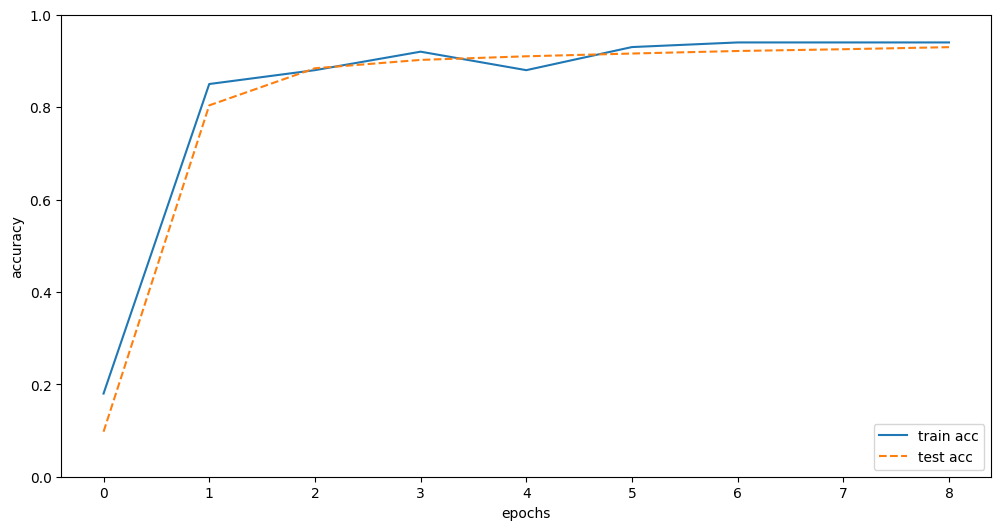

In [85]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6 

# Accuracy 그래프 그리기
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

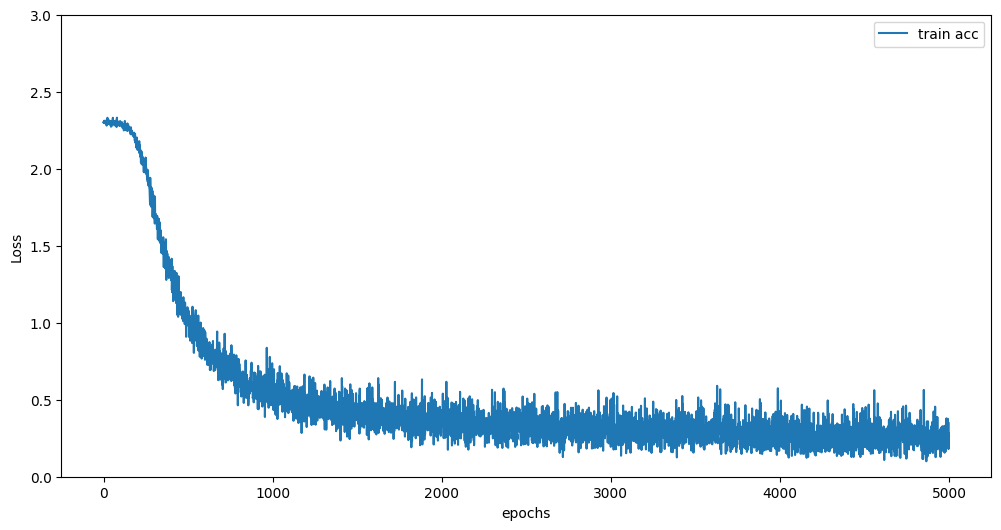

In [86]:
# Loss 그래프 그리기
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='train acc')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.ylim(0, 3.0)
plt.legend(loc='best')
plt.show()